In [1]:
## K-means Clustering on merge_data subsets
## Don't forget to use 'R.k_split'

In [2]:
# packages
import numpy as np
import pandas as pd
import seaborn as sns

# Import packages for k-means clustering
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA

In [3]:
# Import dataset
datafile = "../build/merge_data.csv"
labels_file = "../build/merge_labels.csv"

In [4]:
# Import respective sets of data and labels
data = np.genfromtxt(
    datafile,
    delimiter=',',
    usecols=range(1, 12),
    skip_header=1,
)

true_label_names = np.genfromtxt(
    labels_file,
    delimiter=',',
    usecols=(1,),
    dtype="str",
    skip_header=1,
)

In [5]:
# Double check on data
data[:1]

array([[1.09229594e+03, 3.76653773e+01, 1.57836491e+02, 1.24200000e+01,
        3.10256410e-01, 8.44669380e-01, 1.05979845e+00, 4.09310345e+02,
        1.68909000e+00, 1.66944611e-01, 1.54333333e+00]])

In [6]:
# Convert labels into integers with LabelEncoder
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(true_label_names)
true_labels[0:]

array([1, 0, 1, 1, 0, 1, 1, 1])

In [7]:
# label_encoder.classes_
n_clusters = len(label_encoder.classes_)

In [8]:
# Setup a preprocessing pipeline
preprocessor = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("pca", PCA(n_components=2, random_state=42)),
    ]
)

# Setup k-means clustering pipeline
clusterer = Pipeline(
    [
        (
            "kmeans",
            KMeans(
                n_clusters=n_clusters,
                init="k-means++",
                n_init=50,
                max_iter=500,
                random_state=42,
            ),
        ),
    ]
)

In [9]:
# Setup pipeline from both previous one
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

In [10]:
# Fit the data to the pipeline
pipe.fit(data)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=42))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=2, n_init=50,
                                         random_state=42))]))])

In [11]:
# Evaluate the performance by calculating the silhouette coefficient of the model

# A silhouette coefficient of 0 indicates that clusters are significantly
# overlapping one another, and a silhouette coefficient of 1 indicates 
# clusters are well-separated.

preprocessed_data = pipe["preprocessor"].transform(data)
predicted_labels = pipe["clusterer"]["kmeans"].labels_
silhouette_score(preprocessed_data, predicted_labels)

0.39874800864942517

In [12]:
# An ARI score of 0 indicates that cluster labels are randomly assigned,
# and ARI score of 1 means that the true labels and predicted labels form
# identical clusters.

adjusted_rand_score(true_labels, predicted_labels)

1.0

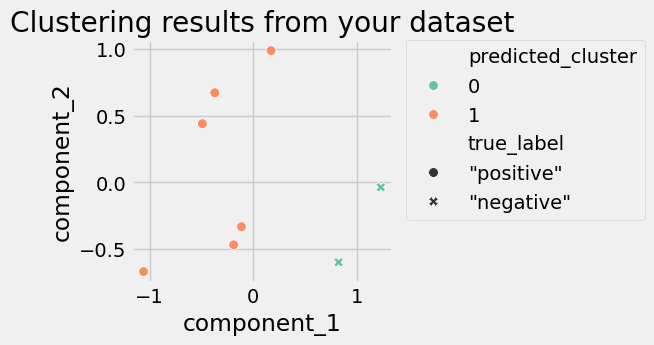

In [13]:
# Plot clustering with pandas

pcadf = pd.DataFrame(
    pipe["preprocessor"].transform(data),
    columns=["component_1", "component_2"],
)

pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_
pcadf["true_label"] = label_encoder.inverse_transform(true_labels)

plt.style.use("fivethirtyeight")
plt.figure(figsize=(3, 3))

scat = sns.scatterplot(
data=pcadf,
x="component_1",
y="component_2",
s=50,
hue="predicted_cluster",
style="true_label",
palette="Set2",
)

scat.set_title(
    "Clustering results from your dataset"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()

In [14]:
# Parameter tuning

## Consist of sequentially altering one of the input values of the algorithm's parameters
## and recording the results. Gives a set of performance scores, one for each new value
## of a given parameter. Maximize the performance from the clustering pipeline.

# Empty lists to hold evaluation metrics
silhouette_scores = []
ari_scores = []
for n in range(2, 5):
    # This set the number of components for pca,
    # but leaves other steps unchanged
    pipe["preprocessor"]["pca"].n_components = n
    pipe.fit(data)

    silhouette_coef = silhouette_score(
        pipe["preprocessor"].transform(data),
        pipe["clusterer"]["kmeans"].labels_,
    )
    ari = adjusted_rand_score(
        true_labels,
        pipe["clusterer"]["kmeans"].labels_,
    )

    # Add metrics to their lists
    silhouette_scores.append(silhouette_coef)
    ari_scores.append(ari)

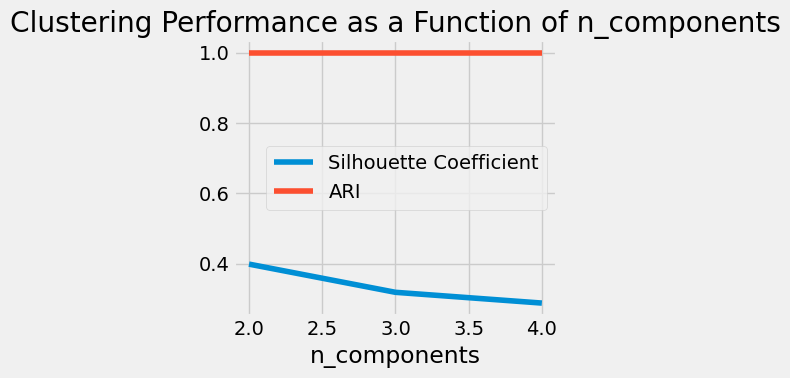

In [15]:
# Plot the stuff

plt.style.use("fivethirtyeight")
plt.figure(figsize=(4, 4))
plt.plot(
    range(2, 5),
    silhouette_scores,
    c="#008fd5",
    label="Silhouette Coefficient",
)
plt.plot(range(2, 5), ari_scores, c="#fc4f30", label="ARI")

plt.xlabel("n_components")
plt.legend()
plt.title("Clustering Performance as a Function of n_components")
plt.tight_layout()
plt.show()